In [3]:
import csv
import pandas

In [5]:
data = pandas.read_csv("data/qsar-biodeg.csv")
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,2
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,2
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,5.431,2.8955,0,0,0,2,0,32.1,4,1,...,0,6,1,3.573,2.242,1,8.088,0,0,1
1051,5.287,3.3732,0,0,9,0,0,35.3,0,9,...,0,3,0,3.787,3.083,3,9.278,0,0,1
1052,4.869,1.7670,0,1,9,0,5,44.4,0,4,...,4,13,0,3.848,2.576,5,9.537,1,0,1
1053,5.158,1.6914,2,0,36,0,9,56.1,0,0,...,1,16,0,5.808,2.055,8,11.055,0,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5023e9bc10>]],
      dtype=object)

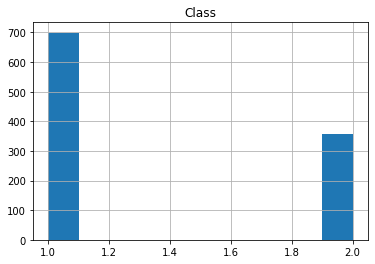

In [7]:
data.hist('Class')

In [13]:
import numpy as np

features = data.drop("Class", 1).to_numpy().astype(np.float32)
labels = (data["Class"].to_numpy() - 1).astype(np.int64)
num_features = features.shape[1]
num_classes = 2

In [25]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [63]:
import sklearn.datasets
import sklearn.pipeline
import sklearn.preprocessing
import skorch

import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(num_features, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

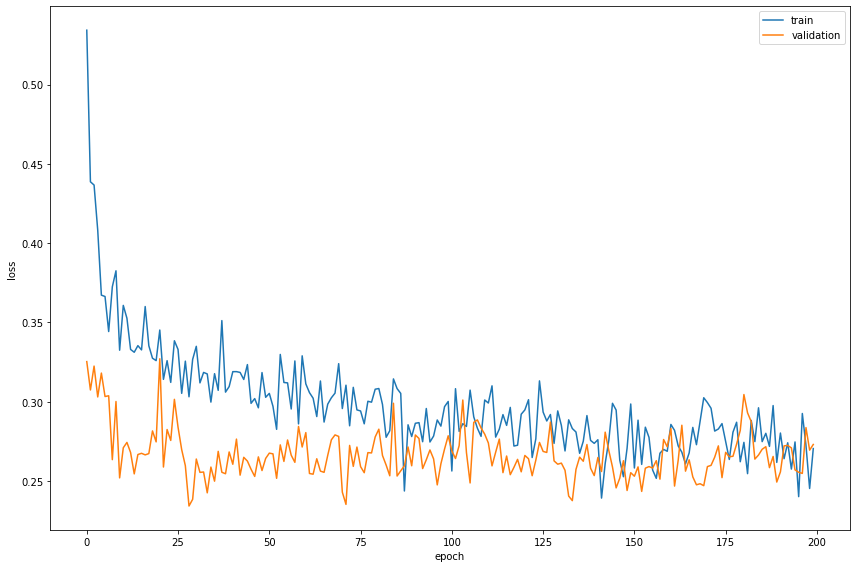

In [61]:
import matplotlib.pyplot as plt

# Learn single model
net = NeuralNetClassifier(
    MyModule,
    max_epochs=200,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.NLLLoss,
    # Shuffle training data on each epoch
    batch_size=8,
    iterator_train__shuffle=True,
    verbose=False,
)

pipe = sklearn.pipeline.Pipeline([
    ('scale', sklearn.preprocessing.StandardScaler()),
    ('net', net),
])

pipe.fit(features, labels)

history = net.history
x = list(range(len(history[:, 'valid_loss'])))

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, history[:, 'train_loss'], label='train')
ax.plot(x, history[:, 'valid_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()

In [64]:
# Cross-validation
import sklearn.model_selection

net = NeuralNetClassifier(
    MyModule,
    max_epochs=200,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.NLLLoss,
    # Shuffle training data on each epoch
    batch_size=8,
    iterator_train__shuffle=True,
    verbose=False,
)

pipe = sklearn.pipeline.Pipeline([
    ('scale', sklearn.preprocessing.StandardScaler()),
    ('net', net),
])

cv_results = sklearn.model_selection.cross_validate(
    pipe, features, labels, cv=10, return_train_score=False, verbose=True, n_jobs=6)
print(cv_results['test_score'])
print(np.mean(cv_results['test_score']))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[0.86792453 0.81132075 0.68867925 0.91509434 0.87735849 0.87619048
 0.82857143 0.81904762 0.87619048 0.81904762]
0.8379424977538186


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:  2.1min finished
